In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate()
; 

  Activating project at `c:\Users\andre\.cursor-tutor-2\Rxinfer.jl\examples`


In [155]:
using RxInfer, Random, BenchmarkTools, Distributions, LinearAlgebra, Plots, LaTeXStrings

In [6]:
function rand_vec(rng, distribution::Categorical)
    return [i == rand(rng, distribution) ? 1.0 : 0.0 for i in 1:ncategories(distribution)]
end

# use MersenneTwister rng to sample from 50-50 Cat dist; it will return
function generate_data(n_samples; seed = 42)
    rng = MersenneTwister(seed)
    observations = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    for t = 1:n_samples
        observations[t] = rand_vec(rng, Categorical([0.5, 0.5]))
    end
    return observations
end
data = generate_data(5)  # sample from 50-50 Cat dist using MersenneTwister rng
println("data = $data")  # print data (two-element vector of one-hot encoded observations)
println("argmax.(data) = $(argmax.(data))")  # return index of the selected observation


data = [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]
argmax.(data) = [1, 1, 2, 1, 2]


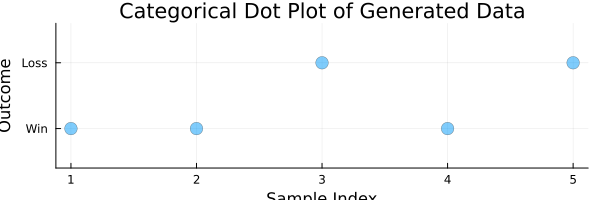

In [7]:
using Plots

function plot_categorical_data(data)
    n_samples = length(data)
    # Convert data to 'Win' and 'Loss' categories
    y_categorical = [x == 1 ? "Win" : "Loss" for x in data]
    # Create the plot
    p = scatter(1:n_samples, y_categorical, 
                markersize = 7, 
                alpha = 0.5, 
                legend = false,
                size = (600, 200),
                ylim = (-0.1, 2.1),
                xlabel = "Sample Index",
                ylabel = "Outcome",
                title = "Categorical Dot Plot of Generated Data")
    # Display the plot
    display(p)
end

plot_categorical_data(argmax.(data))

In [121]:
# # construct priors
# A_1 = MatrixDirichlet(ones(3,2))  # outcome modality
# A_2 = MatrixDirichlet(ones(2,2))  # attention modality

# s_0 = Categorical(fill(1.0 / 3.0, 3))

# B = kron([1 1 1 1; # Row: can I move to 1?
#           0 0 0 0;
#           0 0 0 0;
#           0 0 0 0], I(2))
# println("A_1 = $A_1")
# println("A_2 = $A_2")
# println("s_0 = $s_0")
# println(fill(1.0 / 2.0, 2))
# println("B = $B")
# #println("I(2) = $(Categorical(I(2)))")

In [122]:
eps = 0.0000001   # small number to avoid numerical issues with free energy computation
@model function nkps_model(o1, o2)  # Accept two observations
    A1 ~ MatrixDirichlet([ 1.0 1.0;      # likelihood: outcome modality (rows = imprv/no_imprv/unobserved; columns = self/other)
                           1.0 1.0;    
                           1.0 1.0 ])
    A2 ~ MatrixDirichlet([100.0 eps ;    # likelihood: attention modality (rows = self/neighbor; columns = self/neighbor)
                          eps 100.0 ])
    #A_row_dimensions = length(A_1) + length(A_2)  # number of rows in the joint likelihood matrix
    #A_column_dimensions = size(A_1, 2) + size(A_2, 2)  # number of columns in the joint likelihood matrix
    #A = eps*ones(A_row_dimensions, A_column_dimensions)  #empty joint likelihood matrix

    B ~ MatrixDirichlet([100.0 eps ;     # transitions: attention hidden state factor (rows = self/neighbor; columns = self/neighbor)
                         eps 100.0 ])    
    s_0 ~ Categorical(fill(1.0 / 2.0, 2))
    s_prev = s_0
    
    for t in eachindex(o1)
        s[t] ~ Transition(s_prev, B)  # transition for s_{t-1} to s_{t}
        o1[t] ~ Transition(s[t], A1)  # Use A1 for the first observation
        o2[t] ~ Transition(s[t], A2)  # Use A2 for the second observation
        s_prev = s[t]        #A1_impr_neighbor_history[t] = mean(A1)[1,2]
        print("A1 = $A1")
    end
end

# Constraints specification
@constraints function nkps_model_constraints()
    q(s_0, s, A1, A2, B) = q(s_0, s)q(A1)q(A2)q(B)
end

nkps_model_constraints (generic function with 1 method)

In [123]:
for i in 1:10
    print("$i,")
end

1,2,3,4,5,6,7,8,9,10,

In [166]:
A1test =  MatrixDirichlet([ 1.0 1.0;1.0 1.0; 1.0 1.0 ])
println(size(A1test, 2))
print(mean(A1test)[1,1])
#A1test_mat = mean(A1test)   # annoyingly MatrixDirichlet's indeces must be accessed via conversion to a regular matrix
#print(A1test_mat[2,2])

2
0.3333333333333333

In [125]:
imarginals = @initialization begin
    q(A1) = vague(MatrixDirichlet, 3, 2)
    q(A2) = vague(MatrixDirichlet, 2, 2)
    q(B) = vague(MatrixDirichlet, 2, 2) 
    q(s) = vague(Categorical, 2)
end

ireturnvars = (
    A1 = KeepEach(),
    A2 = KeepLast(),
    B = KeepLast(),
    s = KeepLast(),
)


(A1 = KeepEach(), A2 = KeepLast(), B = KeepLast(), s = KeepLast())

In [139]:
# generate data
context_duration = 30
o1 = [[1.0, 0.0, 0.0] for _ in 1:context_duration]    # see 'improvement
o2 = [[0.0, 1.0] for _ in 1:context_duration]   # attend neighbor
o1 = vcat(o1, [[0.0, 1.0, 0.0] for _ in 1:context_duration])  # now see 'no improvement'
o2 = vcat(o2,[[0.0, 1.0] for _ in 1:context_duration])  # keep attending neighbor
# println("o1[1] with type $(typeof(o1[1]), size $(size(o1[1])) = $o1[1]")
# println("o2[1] with type $(typeof(o2[1]), size $(size(o2[1])) = $o2[1]")
println(o1)
A1_hist = Float64[]

result = infer(
    model         = nkps_model(), 
    data          = (o1 = o1, o2 = o2,),
    constraints   = nkps_model_constraints(),
    initialization = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 100, 
    free_energy   = true,
    #objective_diagnostics = true  # Enable diagnostics
);


[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.

In [140]:
#println(mean(result.posteriors[:A1][1]))

println(result.posteriors[:s])

# Initialize empty vectors
A1_hist_imprv_neighbor = Float64[]
A1_hist_imprv_self = Float64[]
for t in 1:length(result.posteriors[:A1])
    push!(A1_hist_imprv_neighbor, mean(result.posteriors[:A1][t])[1,2]) # Store P(o1=imprv|s=neighbor)
    print("$t P(o1=imprv|s=neighbor) = $(mean(result.posteriors[:A1][t])[1,2])\n")
    push!(A1_hist_imprv_self, mean(result.posteriors[:A1][t])[1,1]) # Store P(o1=imprv|s=self)
end

Categorical{Float64, Vector{Float64}}[Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.0000000000014572e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[1.000000000001e-12, 0.999999999999]), Categorical{Float64, Vector{Float64}}(su

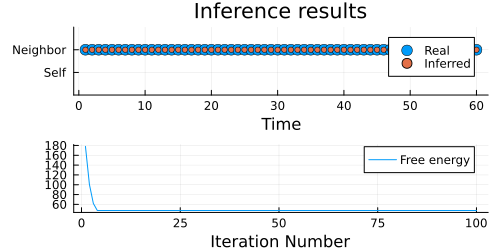

In [147]:
p1 = scatter(argmax.(o2), 
                        title="Inference results", 
                        label = "Real", 
                        ms = 6, 
                        legend=:right,
                        xlabel="Time" ,
                        ylim=(0,3),
                        yticks= ([1,2],["Self","Neighbor"]),
                        size=(500,250)
                        )

p1 = scatter!(p1, argmax.(ReactiveMP.probvec.(result.posteriors[:s])),
                        label = "Inferred",
                        ms = 3
                        )
p2 = plot(result.free_energy, 
                    label="Free energy",
                    xlabel="Iteration Number",size=(500,250)
                    )

plot(p1, p2, layout = @layout([ a; b ]))

In [149]:
typeof(result.free_energy)

Vector{Real} (alias for Array{Real, 1})

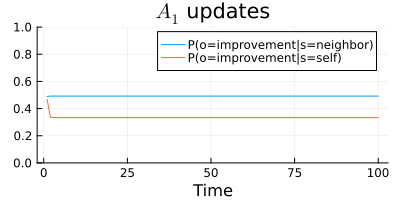

In [163]:
A1_plot = plot(A1_hist_imprv_neighbor, title="$(latexstring("A_1")) updates", label="P(o=improvement|s=neighbor)",xlabel="Time",ylim=(0,1),size=(400,200))
A1_plot = plot!(A1_plot, A1_hist_imprv_self, label="P(o=improvement|s=self)",xlabel="Time",ylim=(0,1))
plot(p3)

In [ ]:
# println(Categorical(fill(1.0 / 3.0, 3)))
# A1_test = MatrixDirichlet([ 1.0 1.0;    # 1=improvement
#                            1.0 1.0;    # 2=no improvement
#                            1.0 1.0 ])  # 3=unobserved
# qA1_test = vague(MatrixDirichlet, 3, 2)
# println("A1_test with type $(typeof(A1_test)), supertype $(supertype(typeof(A1_test))), size $(size(A1_test)) = $(A1_test)")
# println("qA1_test with type $(typeof(qA1_test)), supertype $(supertype(typeof(qA1_test))), size $(size(qA1_test)) = $(qA1_test)")

### Notes

- trying forcing data as 'imprv-neighbor' then 'no_imprv-neighbor' returns strange A1 results, roughly consistently 0.5(why?)